# Simple One Dimensional Example using GANs

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf


#### True data distribution <i>trueDataDistribution<i>

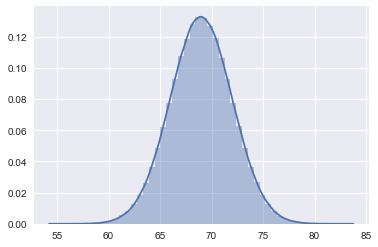

In [2]:
mu = 69
sigma = 3
size = 1000000
trueDataDistribution = np.random.normal(mu,sigma,size)
sns.distplot(trueDataDistribution)


#### Define functions

In [3]:
# Perform matrix multiplication
# for more info: https://towardsdatascience.com/under-the-hood-of-neural-network-forward-propagation-the-dreaded-matrix-multiplication-a5360b33426
def linear(input, output_dim, scope=None, mean=0, stddev=1.0, bias_start=0.0):
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable(
            'w',
            [input.get_shape()[1], output_dim],
            initializer=tf.random_normal_initializer(mean=mean, stddev=stddev)
        )
        b = tf.get_variable(
            'b',
            [output_dim],
            initializer=tf.constant_initializer(bias_start)
        )
        return tf.matmul(input, w) + b

In [4]:
# Perform batch normalization to speed up training
# for more info: https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
def batchnorm(input):
    mean, variance = tf.nn.moments(input, [0])
    output = tf.nn.batch_normalization(input, mean, variance, offset=None, scale=None, variance_epsilon=0.00001)
    return output

In [5]:
# Set dropout percentage to address overfitting
# for more info: https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5
dropout = 0.90

In [6]:
# Set size of hidden units for generator and discriminator
generator_hiddenUnits = 10
discriminator_hiddenUnits = 2

In [7]:
# Define generator - 5 hidden layers, each with 10 nodes
# The generator uses a linear transformation passed through a nonlinearity (hyperbolic tangent) 5 times
# At each hidden layer, we also perform batch normalization and dropout.
# This is followed by a final linear transformation.
def generator(input, generator_hiddenUnits):
    h0 = tf.nn.tanh(batchnorm(linear(input, generator_hiddenUnits, 'g0')))
    h0 = tf.nn.dropout(h0, dropout)
    h1 = tf.nn.tanh(batchnorm(linear(h0, generator_hiddenUnits, 'g1')))
    h1 = tf.nn.dropout(h1, dropout)
    h2 = tf.nn.tanh(batchnorm(linear(h1, generator_hiddenUnits, 'g2')))
    h2 = tf.nn.dropout(h2, dropout)
    h3 = tf.nn.tanh(batchnorm(linear(h2, generator_hiddenUnits, 'g3')))
    h3 = tf.nn.dropout(h3, dropout)
    h4 = tf.nn.tanh(batchnorm(linear(h3, generator_hiddenUnits, 'g4')))
    h4 = tf.nn.dropout(h4, dropout)
    output = linear(h4, 1, 'g5')
    return output

In [8]:
# Define discriminator - 3 hidden layers, each with 2 nodes
# The discriminator uses a linear transformation passed through a nonlinearity (hyperbolic tangent) 3 times.
# This is followed by a final linear transformation passed through a nonlinearity (sigmoid function).
def discriminator(input, discriminator_hiddenUnits):
    h0 = tf.nn.tanh(linear(input, discriminator_hiddenUnits, 'd0'))
    h1 = tf.nn.tanh(linear(h0, discriminator_hiddenUnits, 'd1'))
    h2 = tf.nn.tanh(linear(h1, discriminator_hiddenUnits, 'd2'))
    output = tf.nn.sigmoid(linear(h2, 1, scope='d3'))
    return output

In [9]:
# Define optimization function
def optimizer(loss, var_list):
    initial_learning_rate = 0.005
    decay = 0.96
    num_decay_steps = 100
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

In [10]:
# Define log function to handle near-zero calculations that could result in NaNs during optimization.
def log(x):
    return tf.log(tf.maximum(x, 1e-10))

In [11]:
# Set parameters for training
training_epochs = 10000
batch_size = 200
output_dim = 1
num_stDevs = 5


#### Set up generator and discriminator

In [12]:
# Generator
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape=(batch_size,1)) # create placeholder for one-dimensional array
    G = generator(z_node, output_dim) # run z_node through the generator's neural network

In [13]:
# Discriminator
with tf.variable_scope("D") as scope:
    # D1 takes values from the true data distribution as inputs
    x_node = tf.placeholder(tf.float32, shape=(batch_size,1)) # create placeholder for one-dimensional array
    D1 = discriminator(x_node, output_dim)
    # D2 is copy of D1 but takes values from the generator as inputs
    scope.reuse_variables()
    D2 = discriminator(G, output_dim)

In [14]:
# Set variables for parameters of the generator and the discriminator
vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D/')]
g_params = [v for v in vars if v.name.startswith('G/')]

In [15]:
# Set objectives for the generator and the discriminator
objective_discriminator = tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
objective_generator = tf.reduce_mean(tf.log(D2))

In [16]:
# Set optimizers for the generator and the discriminator
optimizer_discriminator=optimizer(1-objective_discriminator, d_params)
optimizer_generator=optimizer(1-objective_generator, g_params)


#### Initialize the session and plot the results

In [17]:
# Set session and run
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [18]:
# Define plotting function
num_points = 1000
resolution = 5000
def plot_figure(num_points=num_points, resolution = resolution):
    fig, ax1 = plt.subplots(1)
    fig.suptitle('Simple GAN Example using 1-Dimensional Data Distribution')
    plt.xlabel('Data Values')
    plt.ylabel('Probability Density')
    ax1.set_xlim(mu-3*sigma,mu+3*sigma)
    ax1.set_ylim(0,0.5)
    ax2 = ax1.twinx()
    ax2.set_ylim(0,1.1)
    ax2.set_ylabel("Decision Probability")
    
    # decision boundary
    xs = np.linspace(mu-num_stDevs*sigma, mu+num_stDevs*sigma, resolution)
    db = np.zeros((resolution,1))
    for i in range(int(resolution/batch_size)):
        db[batch_size * i:batch_size * (i+1)] = sess.run(
            D1,
            {
                x_node: np.reshape(xs[batch_size * i:batch_size * (i + 1)],
                               (batch_size,1)
                              )
            }
        )
    ax2.plot(xs, db, label='decision boundary', color='b')
    
    # true data distribution
    xs = np.linspace(mu-num_stDevs*sigma, mu+num_stDevs*sigma, num_points)
    ax1.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label="true distribution", color='g')
    
    # synthetic data distribution using generator
    zs = np.linspace(mu-num_stDevs*sigma, mu+num_stDevs*sigma, resolution)
    g = np.zeros((resolution,1))
    for i in range(int(resolution/batch_size)):
        g[batch_size * i:batch_size * (i+1)] = sess.run(
            G,
            {
                z_node: np.reshape(zs[batch_size * i:batch_size * (i + 1)],
                               (batch_size,1)
                              )
            }
        )
    synHist, synEdges = np.histogram(g, bins=10)
    ax1.plot(np.linspace(mu-num_stDevs*sigma,mu+num_stDevs*sigma,10), synHist/float(resolution), label='synthetic distribution', color='r')
    ax1.legend(loc='center left', bbox_to_anchor=(0,0.6))
    ax2.legend(loc=0)
    plt.show()

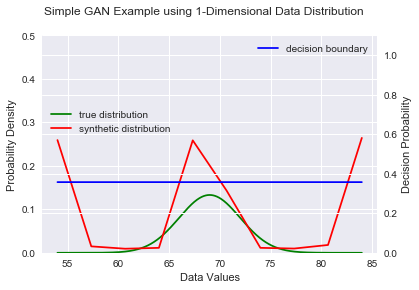

In [19]:
plot_figure()

0.0
Epoch: 0000
Generator Loss: -0.705523133278
Discriminator Loss: -1.70648682117


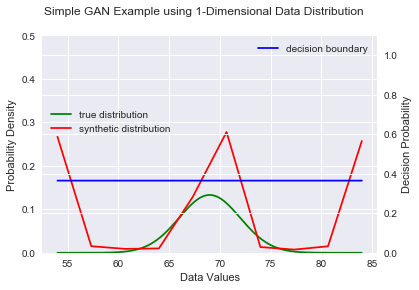

0.1
Epoch: 1000
Generator Loss: -1.86997652054
Discriminator Loss: -0.343787223101


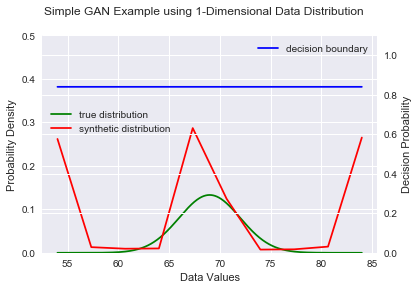

0.2
Epoch: 2000
Generator Loss: -1.81894040108
Discriminator Loss: -0.347071737051


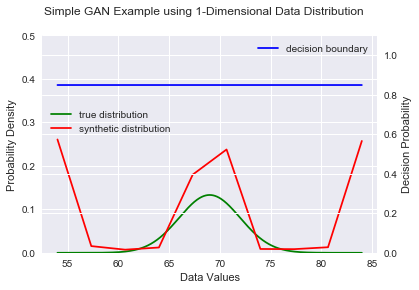

0.3
Epoch: 3000
Generator Loss: -1.59017550945
Discriminator Loss: -0.440151512623


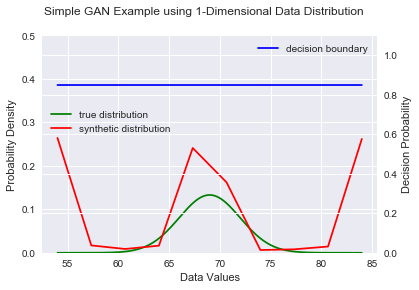

0.4
Epoch: 4000
Generator Loss: -1.36329984665
Discriminator Loss: -0.571755230427


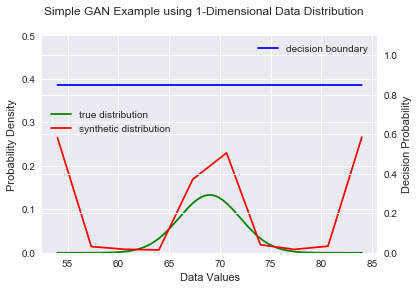

0.5
Epoch: 5000
Generator Loss: -1.2250970602
Discriminator Loss: -0.649926245213


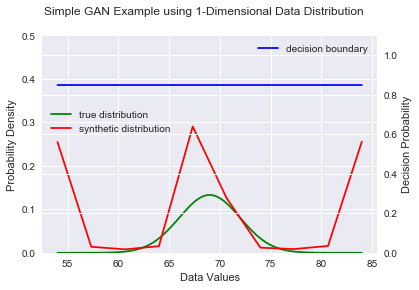

0.6
Epoch: 6000
Generator Loss: -1.12664616108
Discriminator Loss: -0.727328419685


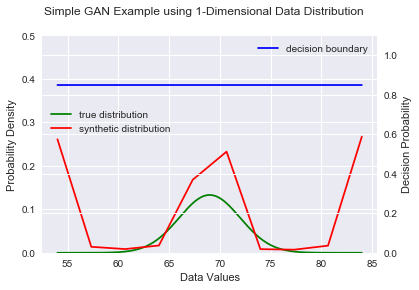

0.7
Epoch: 7000
Generator Loss: -1.09207046032
Discriminator Loss: -0.743252158165


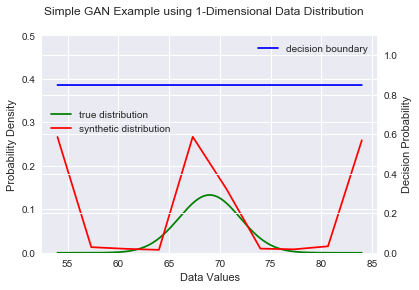

0.8
Epoch: 8000
Generator Loss: -1.05258715153
Discriminator Loss: -0.807259321213


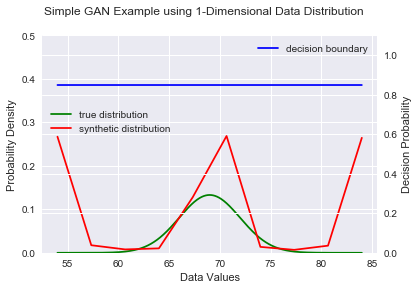

0.9
Epoch: 9000
Generator Loss: -1.00767636299
Discriminator Loss: -0.810094535351


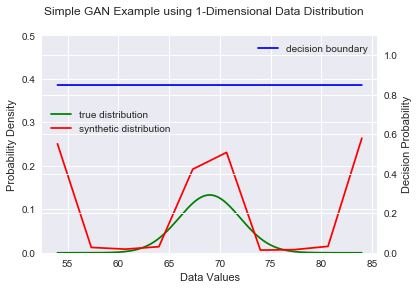

In [20]:
# Algorithm by Goodfellow et al. 2014
k=10
histDiscriminator, histGenerator = np.zeros(training_epochs), np.zeros(training_epochs)
for i in range(training_epochs):
    # discriminator
    for j in range(k):
        x = np.random.normal(mu,sigma,batch_size) # sampled m-batch from true data distribution
        x.sort()
        z = np.linspace(mu-num_stDevs*sigma, mu+num_stDevs*sigma, batch_size) + np.random.random(batch_size) * 0.50 # sample m-batch with noise
        histDiscriminator[i], _ = sess.run([objective_discriminator,optimizer_discriminator], 
                                           {x_node: np.reshape(x,(batch_size,1)), z_node: np.reshape(z,(batch_size,1))})
    # generator
    z = np.linspace(mu-num_stDevs*sigma, mu+num_stDevs*sigma, batch_size) + np.random.random(batch_size) * 0.50  # sample m-batch with noise
    histGenerator[i], _ = sess.run([objective_generator,optimizer_generator], 
                                   {z_node: np.reshape(z,(batch_size,1))})
    
    # print results
    if i % (training_epochs//10) == 0:
        print(float(i)/float(training_epochs))
        print("Epoch:", '%04d' % (i))
        print("Generator Loss:", histGenerator[i])
        print("Discriminator Loss:", histDiscriminator[i])
        plot_figure()

#### The discriminator is good at finding the synthetic data points.
#### But, the generator improves over time based on feedback that the discriminator provides.